## Ensemble of 3-Seeded Neural Networks from Scratch (Submission 1 - Beats Baseline - Submitted on 31 Nov/1st Dec)

### Public Score: 0.485, Private Score: 0.515

### file name on kaggle: nn_ensemble_Scratch.csv

#### around 100 seconds to train all 3 seeds and ensemble

In [1]:
import numpy as np
import pandas as pd

from nn_utils import load_train_data, load_test_data, Scaler_Scratch, stratified_train_test_indices, predict_tta
from nn_trainer import train_nn_model, plot_confusion_matrix_heatmap, classification_report_np, plot_loss_curves, confusion_matrix_np

#### Define seeds and hyperparams

In [2]:
SEEDS = [2596, 42, 1206]

num_classes = 5

#define hyperparameters (passed in train_nn_model)
hyperparams_dict = {
    "num_classes": num_classes,
    "input_dim": 28 * 28 * 3,  # IMG_H * IMG_W * IMG_C
    "batch_size": 64,
    "epochs": 40,
    "lr_initial": 0.002,
    "momentum": 0.9,
    "dropout_prob": 0.25,
    "weight_decay": 1e-4,
}


height, width, channels = 28, 28, 3

#### Load train and test data

In [3]:
images, labels = load_train_data("Data/train_data.pkl")
test_images = load_test_data("Data/test_data.pkl")

images.shape, labels.shape, test_images.shape

((1080, 28, 28, 3), (1080,), (400, 28, 28, 3))

#### Apply Standard Scaler (scratch) and Stratified Train-Validation Split

In [4]:
#Convert to floas first
X_float = images.astype(np.float32) / 255.0

#Flatten
X_flat = X_float.reshape(len(X_float), -1)

#Standardize using Scaler_Scratch
scaler = Scaler_Scratch().normalize_train(X_flat)

X_flat.shape

(1080, 2352)

#### Stratified Validation Split (ratio: 0.15) + Standardize validation set using a version of fit_transform (fn name: normalize)

In [5]:

#Shuffle and stratify indices using seed
train_idx, val_idx = stratified_train_test_indices(labels, 0.15, num_classes, 999)

#X_train's indices are passed directly to the nn_model.
X_train = images[train_idx].astype(np.float32) / 255.0
X_train_flat = X_train.reshape(len(X_train), -1)

X_val = images[val_idx].astype(np.float32) / 255.0
y_val = labels[val_idx]

X_val_flat = X_val.reshape(len(X_val), -1)
X_val_scaled = scaler.normalize(X_val_flat)

X_test = test_images.astype(np.float32) / 255.0
X_test_flat = X_test.reshape(len(X_test), -1)
X_test_scaled = scaler.normalize(X_test_flat)

X_train_flat.shape, X_val_flat.shape, X_test_flat.shape

((921, 2352), (159, 2352), (400, 2352))

#### Train NN Model Ensemble for all Seeds  + Test Time Augmentation while Predicting

In [6]:
#Pass data params to train_nn_model function

train_data_dict = {
    "images": images,
    "labels": labels,
    "train_idx": train_idx, # for X_train's split
    "scaler": scaler,
    "X_val_scaled": X_val_scaled,
    "y_val": y_val,
}

In [7]:

#Accumulators for ensemble predictions
n_val = len(X_val_scaled)
n_test = len(X_test_scaled)

#these hold all predictions for all the seeds...we just do an average in the end
val_probs  = np.zeros((n_val, num_classes), dtype=np.float32)
test_probs = np.zeros((n_test, num_classes), dtype=np.float32)


Training ensemble of 3 NN models...

Training NN with seed 2596
Epoch 0: train loss: 1.8153 | val loss: 1.7024
Epoch 10: train loss: 1.4333 | val loss: 1.4309
Learning rate decayed to 0.0002
Epoch 20: train loss: 1.4211 | val loss: 1.4029
Epoch 30: train loss: 1.3673 | val loss: 1.3907
Epoch 39: train loss: 1.3670 | val loss: 1.3765


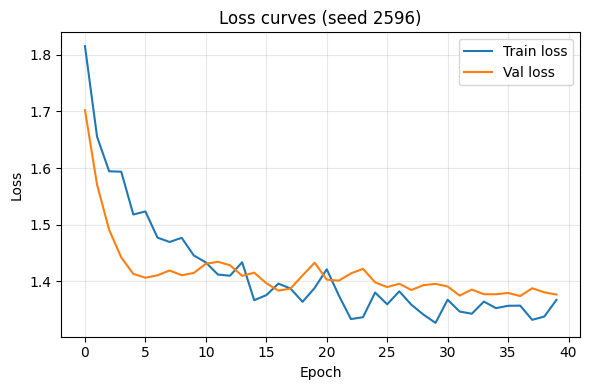


Training NN with seed 42
Epoch 0: train loss: 1.7974 | val loss: 1.6581
Epoch 10: train loss: 1.4437 | val loss: 1.4375
Learning rate decayed to 0.0002
Epoch 20: train loss: 1.3721 | val loss: 1.4115
Epoch 30: train loss: 1.4083 | val loss: 1.3924
Epoch 39: train loss: 1.3585 | val loss: 1.3955


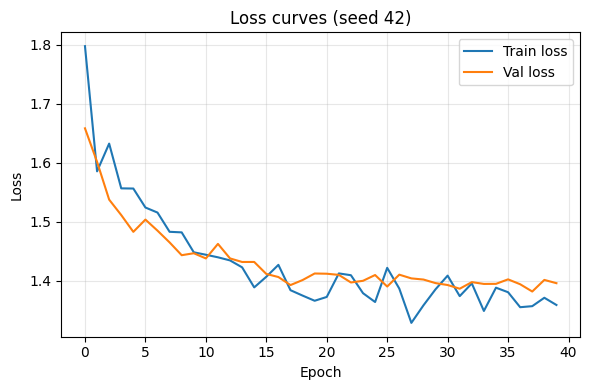


Training NN with seed 1206
Epoch 0: train loss: 1.9216 | val loss: 1.6656
Epoch 10: train loss: 1.4506 | val loss: 1.4272
Learning rate decayed to 0.0002
Epoch 20: train loss: 1.3822 | val loss: 1.4011
Epoch 30: train loss: 1.3910 | val loss: 1.3893
Epoch 39: train loss: 1.3891 | val loss: 1.3818


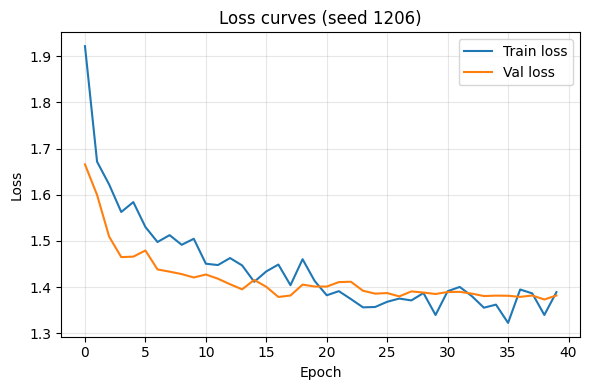


 --Validation Results--
Validation Accuracy: 0.4717

Cls  Prec     Rec      F1       Support 
----------------------------------------
0    0.7260    0.7361    0.7310    72      
1    0.2500    0.1579    0.1935    19      
2    0.2778    0.3333    0.3030    30      
3    0.3214    0.3103    0.3158    29      
4    0.0000    0.0000    0.0000    9       


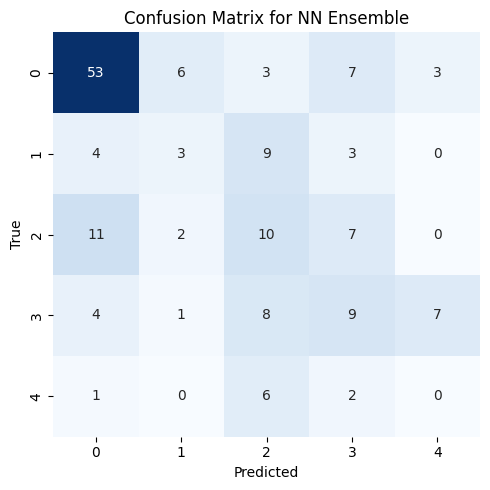

In [8]:

#Training loop for every seed

print(f"\nTraining ensemble of {len(SEEDS)} NN models...")

for seed in SEEDS:

    #Call trainer and pass params
    model, train_losses, val_losses = train_nn_model(seed,train_data_dict, hyperparams_dict)
    
    #Plot training and loss curves
    plot_loss_curves(train_losses, val_losses, seed)
    
    #Do test time augmentation and predictions on the validation and test sets
    #Accumulate predictions and later divide to average predictions
    
    val_probabilities = predict_tta(model, X_val_scaled, scaler, height, width, channels)
    val_probs += val_probabilities
    
    test_probabilities = predict_tta(model, X_test_scaled, scaler, height, width, channels)
    test_probs += test_probabilities

#Evaluate validation predictions

#Classification report (from scratch)
val_pred = np.argmax(val_probs, axis=1)
report = classification_report_np (y_val, val_pred, num_classes)

#Confusion matrix (from scratch)
conf_mat = confusion_matrix_np (y_val, val_pred, num_classes)

plot_confusion_matrix_heatmap(conf_mat, class_names=[str(i) for i in range(num_classes)], title="Confusion Matrix for NN Ensemble" )


##### Save preds to csv

In [9]:
test_pred = np.argmax(test_probs, axis=1)

submission_dict = {
     "ID": np.arange(1, len(test_pred) + 1),
    "label": test_pred,   
}

submission = pd.DataFrame(submission_dict)
submission.to_csv("nn_ensemble_Scratch.csv", index=False)
print(f"Saved csv")

Saved csv
